In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/10-monkey-species/monkey_labels.txt
/kaggle/input/10-monkey-species/validation/validation/n8/n816.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n810.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n8016.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n809.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n801.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n806.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n804.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n811.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n815.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n813.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n8011.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n8012.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n8031.jpg
/kaggle/input/10-monkey-species/validation/validation/n8/n8015.jpg
/kaggle/input/10-monk

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.4.1
sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.3
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.1
tensorflow 2.4.1
tensorflow.keras 2.4.0


In [3]:
train_dir = "/kaggle/input/10-monkey-species/training/training"
valid_dir = "/kaggle/input/10-monkey-species/validation/validation"
label_file = "/kaggle/input/10-monkey-species/monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n8', 'n6', 'n7', 'n1', 'n0', 'n2', 'n5', 'n4', 'n9', 'n3']
['n8', 'n6', 'n7', 'n1', 'n0', 'n2', 'n5', 'n4', 'n9', 'n3']


In [4]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [16]:
# resnet处理的图像尺寸
height = 224
width = 224
channels = 3
batch_size = 24
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
#     rescale = 1./255, # 归一化
    preprocessing_function=keras.applications.resnet50.preprocess_input, # resnet对图像做的处理，归一化到[-1,1]
    rotation_range = 40, # 图像增强方法
    width_shift_range = 0.2, # 位移，图片位移的鲁棒性，在[0,20%]之间随机选择一个数进行平移
    height_shift_range = 0.2,
    shear_range = 0.2, # 剪切强度
    zoom_range = 0.2, # 缩放强度
    horizontal_flip = True,  # 是否要随机的水平翻转
    fill_mode = 'nearest', # 像素填充规则
)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (height, width),
                                                   batch_size = batch_size,
                                                   seed = 7,
                                                   shuffle = True,
                                                   class_mode = "categorical")
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False, # 不用训练，所以不用混排
                                                    class_mode = "categorical") # label的格式，这里使用onehot编码后的格式
train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)



Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [6]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0

In [7]:
resnet50_fine_tune = keras.models.Sequential()
# resnet50针对imagenet训练的，分类个数是1000类，所以要将最后一层去掉include_top=False;
# resnet50倒数第二层的输出是卷积层的输出，是一个三维矩阵而不是一个向量，无法直接连接全连接层，通过加pooling层进行处理
# weights=None,从头开始训练，weights=imagenet,下载imagenet训练好的模型，初始化网络结构
resnet50_fine_tune.add(keras.applications.ResNet50(include_top=False,
                                                  pooling = 'avg',
                                                  weights = 'imagenet'))

# 加全连接层
resnet50_fine_tune.add(keras.layers.Dense(num_classes, activation='softmax'))

# 将resnet这一层trainable设置为False
resnet50_fine_tune.layers[0].trainable = False

# 对于finetune模型来说，sgd是比较好的模型优化器
resnet50_fine_tune.compile(loss="categorical_crossentropy",
                          optimizer='sgd', metrics=['accuracy'])
resnet50_fine_tune.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
epochs = 10
history = resnet50_fine_tune.fit_generator(train_generator,
                             steps_per_epoch = train_num // batch_size,
                             epochs = epochs,
                             validation_data = valid_generator,
                             validation_steps = valid_num // batch_size)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
45/45 [==============================] - 66s 1s/step - loss: 1.6356 - accuracy: 0.4856 - val_loss: 0.4606 - val_accuracy: 0.9091
Epoch 2/10
45/45 [==============================] - 40s 902ms/step - loss: 0.3696 - accuracy: 0.9348 - val_loss: 0.2527 - val_accuracy: 0.9545
Epoch 3/10
45/45 [==============================] - 39s 880ms/step - loss: 0.2403 - accuracy: 0.9523 - val_loss: 0.1807 - val_accuracy: 0.9735
Epoch 4/10
45/45 [==============================] - 38s 859ms/step - loss: 0.1767 - accuracy: 0.9727 - val_loss: 0.1437 - val_accuracy: 0.9773
Epoch 5/10
45/45 [==============================] - 39s 871ms/step - loss: 0.1444 - accuracy: 0.9689 - val_loss: 0.1288 - val_accuracy: 0.9773
Epoch 6/10
45/45 [==============================] - 39s 861ms/step - loss: 0.1404 - accuracy: 0.9744 - val_loss: 0.1150 - val_accuracy: 0.9811
Epoch 7/10
45/45 [==============================] - 39s 884ms/step - loss: 0.1070 - accuracy: 0.9847 - val_loss: 0.0972 - val_accuracy: 0.9848
Ep

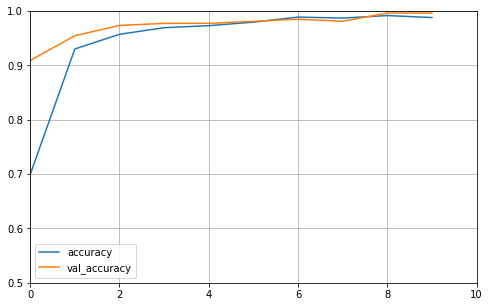

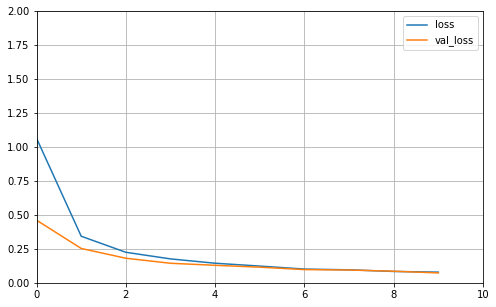

In [11]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0.5, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [22]:
# 定义模型，可以对resnet50的后几层也可以训练
resnet50 = keras.applications.ResNet50(include_top = False,
                                       pooling = 'avg',
                                       weights = 'imagenet')
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [23]:
for layer in resnet50.layers[0:-5]:
    layer.trainable = False

resnet50_new = keras.models.Sequential([
    resnet50,
    keras.layers.Dense(num_classes, activation = 'softmax'),
])
resnet50_new.compile(loss="categorical_crossentropy",
                     optimizer="sgd", metrics=['accuracy'])
resnet50_new.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_5 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 1,075,210
Non-trainable params: 22,532,992
_________________________________________________________________


In [24]:
epochs = 10
history = resnet50_new.fit_generator(train_generator,
                                     steps_per_epoch = train_num // batch_size,
                                     epochs = epochs,
                                     validation_data = valid_generator,
                                     validation_steps = valid_num // batch_size)

Epoch 1/10
45/45 [==============================] - 44s 927ms/step - loss: 1.6472 - accuracy: 0.4885 - val_loss: 0.3137 - val_accuracy: 0.9508
Epoch 2/10
45/45 [==============================] - 39s 873ms/step - loss: 0.3519 - accuracy: 0.9497 - val_loss: 0.2036 - val_accuracy: 0.9735
Epoch 3/10
45/45 [==============================] - 39s 877ms/step - loss: 0.2150 - accuracy: 0.9670 - val_loss: 0.1584 - val_accuracy: 0.9773
Epoch 4/10
45/45 [==============================] - 40s 882ms/step - loss: 0.1541 - accuracy: 0.9721 - val_loss: 0.1238 - val_accuracy: 0.9848
Epoch 5/10
45/45 [==============================] - 40s 877ms/step - loss: 0.1212 - accuracy: 0.9797 - val_loss: 0.1088 - val_accuracy: 0.9886
Epoch 6/10
45/45 [==============================] - 39s 868ms/step - loss: 0.1007 - accuracy: 0.9861 - val_loss: 0.0947 - val_accuracy: 0.9886
Epoch 7/10
45/45 [==============================] - 39s 876ms/step - loss: 0.0971 - accuracy: 0.9835 - val_loss: 0.0868 - val_accuracy: 0.9886

### 从上面的结果可以看出，修改了resnet50的后几层训练的效果比不训练要差一些，原因可能有：
- 可训练参数变多了，要想达到比较好的收敛效果需要更长的时间
- 在最后的可以训练的几层中，可以分为两类，一类是resnet50的最后基层，一类是新加的没有经过训练的全连接层，resnet后五层是经过训练且达到比较好的状态的，我们此时设置相同的learning_rate比较大，就有可能将resnet的后几层的较好的模型效果给破坏掉，再回到较好转态需要时间。

### 解决方式就是将learning_rate设置的小一些，增加迭代的次数

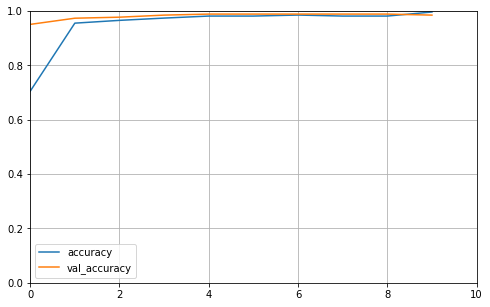

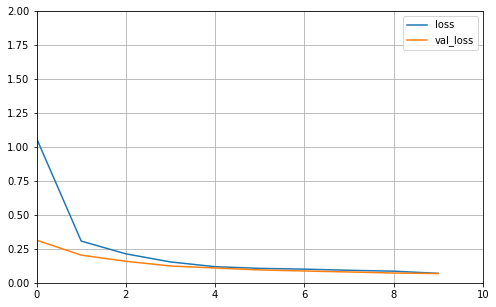

In [26]:
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)